In [36]:
import geopandas as gpd
gpd.options.use_pygeos = True
import pandas as pd
import numpy as np

import shapely

from sqlalchemy import create_engine
from secrets.con_str import con_str

engine = create_engine(con_str)

In [30]:
sql = """
SELECT gid, pin, geom
FROM parcels;
"""
parcels_gdf = gpd.read_postgis(sql, engine)
parcels_gdf

,gid,pin,geom
0,388302,0941D00028000000,"MULTIPOLYGON (((1320469.675 465729.058, 132027..."
1,388303,0142R00268000000,"MULTIPOLYGON (((1326687.125 388538.216, 132661..."
2,388304,0663B00012000000,"MULTIPOLYGON (((1343615.363 365428.463, 134349..."
3,388305,0059R00172000000,"MULTIPOLYGON (((1349278.375 394534.908, 134928..."
4,388306,0007D00222000000,"MULTIPOLYGON (((1337001.507 415109.561, 133694..."
...,...,...,...
583672,388297,1240A00094000000,"MULTIPOLYGON (((1422476.375 420132.783, 142235..."
583673,388298,2374K00015000000,"MULTIPOLYGON (((1327926.958 495161.709, 132810..."
583674,388299,0666S00114000000,"MULTIPOLYGON (((1331068.750 363335.781, 133104..."
583675,388300,0302K00154000000,"MULTIPOLYGON (((1380790.500 394971.783, 138078..."


In [31]:
parcels_gdf.to_feather('parcels_gdf.feather')

/var/folders/6q/n3pxz9m53xq52fgdhf0cbl8h0000gn/T/ipykernel_93434/1255718169.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  parcels_gdf.to_feather('parcels_gdf.feather')


In [3]:
boundaries_gser = parcels_gdf['geom'].explode(ignore_index=True).boundary.explode(ignore_index=True)

In [4]:
print(len(boundaries_gser))
print(boundaries_gser.geom_type.unique())

592571
['LineString']


In [5]:
# polygonized_gser = gpd.GeoSeries(shapely.ops.polygonize(boundaries_gser.unary_union))

In [6]:
boundaries_union = boundaries_gser.unary_union

In [7]:
union_polygonized = shapely.ops.polygonize(boundaries_union)

In [8]:
polygonized_gser = gpd.GeoSeries(union_polygonized)

In [9]:
print(polygonized_gser.geom_type.unique())

['Polygon']


In [18]:
# gpd.GeoDataFrame(polygonized_gser.rename('geometry')).to_postgis("parcels_polygonized_gpd", con=engine)

In [10]:
gpd.GeoDataFrame(polygonized_gser.rename('geometry')).to_feather("parcels_polygonized.feather")

/var/folders/6q/n3pxz9m53xq52fgdhf0cbl8h0000gn/T/ipykernel_93434/4175963604.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  gpd.GeoDataFrame(polygonized_gser.rename('geometry')).to_feather("parcels_polygonized.feather")


In [11]:
polygonized_gdf = gpd.read_feather('parcels_polygonized.feather')

In [12]:
polygonized_gdf

,geometry
0,"POLYGON ((1320469.675 465729.058, 1320278.867 ..."
1,"POLYGON ((1320278.867 465727.066, 1320469.675 ..."
2,"POLYGON ((1320257.992 465726.400, 1320278.867 ..."
3,"POLYGON ((1320117.842 465786.949, 1320121.301 ..."
4,"POLYGON ((1320117.808 465789.228, 1320117.842 ..."
...,...
603585,"POLYGON ((1310724.208 402283.152, 1310789.923 ..."
603586,"POLYGON ((1422647.466 425211.932, 1422681.462 ..."
603587,"POLYGON ((1312322.363 404008.561, 1312350.669 ..."
603588,"POLYGON ((1394407.690 467581.995, 1394402.112 ..."


In [19]:
joined_gdf = polygonized_gdf.set_crs(parcels_gdf.crs).sjoin(parcels_gdf, how="left")

In [29]:
joined_gdf[['gid']].reset_index().rename(columns={'gid':'parcel_gid', 'index':'split_poly_gid'}).to_feather('joined_gids.feather')

In [35]:
gid_join_df = pd.read_feather('joined_gids.feather')
gid_join_df

,split_poly_gid,parcel_gid
0,0,82615
1,0,322338
2,0,564810
3,0,388302
4,0,486437
...,...,...
2638334,603587,373324
2638335,603587,388005
2638336,603588,287956
2638337,603588,388206


In [41]:
split_poly_pin_merge_df = gid_join_df.merge(parcels_gdf[['gid', 'pin']], left_on='parcel_gid', right_on='gid').drop('gid', axis=1)[['split_poly_gid',	'pin']]
split_poly_pin_merge_df

,split_poly_gid,pin
0,0,0941D00119000000
1,1,0941D00119000000
2,2,0941D00119000000
3,3,0941D00119000000
4,35420,0941D00119000000
...,...,...
2638334,603570,0116K00147000000
2638335,603572,0023G00174000000
2638336,603581,0020M00059000000
2638337,603582,0134B00134000000


In [48]:
pin_lists = pd.pivot_table(
  split_poly_pin_merge_df,
  # .sort_values('split_poly_gid').set_index('split_poly_gid'),
  index='split_poly_gid',
  values=['pin'],
  aggfunc=lambda x:list(x)
)

pin_lists

,pin
split_poly_gid,
0,"[0941D00119000000, 0941D00043000000, 0941D0013..."
1,"[0941D00119000000, 0941D00043000000, 0941D0002..."
2,"[0941D00119000000, 0941D00043000000, 0941D0013..."
3,"[0941D00119000000, 0941D00136000000, 0941D0002..."
4,"[0941D00136000000, 0941D00028000000, 0941D0013..."
...,...
603585,"[0148E00002000000, 8000T01114000000]"
603586,"[1239E00386000000, 8000T03554000000]"
603587,"[0149L00150000000, 8000T01319000000]"


In [49]:
polygonized_gdf.join(pin_lists)

,geometry
0,"POLYGON ((1320469.675 465729.058, 1320278.867 ..."
1,"POLYGON ((1320278.867 465727.066, 1320469.675 ..."
2,"POLYGON ((1320257.992 465726.400, 1320278.867 ..."
3,"POLYGON ((1320117.842 465786.949, 1320121.301 ..."
4,"POLYGON ((1320117.808 465789.228, 1320117.842 ..."
...,...
603585,"POLYGON ((1310724.208 402283.152, 1310789.923 ..."
603586,"POLYGON ((1422647.466 425211.932, 1422681.462 ..."
603587,"POLYGON ((1312322.363 404008.561, 1312350.669 ..."
603588,"POLYGON ((1394407.690 467581.995, 1394402.112 ..."


In [53]:
polygonized_gdf = polygonized_gdf.merge(
  pin_lists,
  how='left',
  left_index=True,
  right_index=True
)
polygonized_gdf

,geometry,pin
0,"POLYGON ((1320469.675 465729.058, 1320278.867 ...","[0941D00119000000, 0941D00043000000, 0941D0013..."
1,"POLYGON ((1320278.867 465727.066, 1320469.675 ...","[0941D00119000000, 0941D00043000000, 0941D0002..."
2,"POLYGON ((1320257.992 465726.400, 1320278.867 ...","[0941D00119000000, 0941D00043000000, 0941D0013..."
3,"POLYGON ((1320117.842 465786.949, 1320121.301 ...","[0941D00119000000, 0941D00136000000, 0941D0002..."
4,"POLYGON ((1320117.808 465789.228, 1320117.842 ...","[0941D00136000000, 0941D00028000000, 0941D0013..."
...,...,...
603585,"POLYGON ((1310724.208 402283.152, 1310789.923 ...","[0148E00002000000, 8000T01114000000]"
603586,"POLYGON ((1422647.466 425211.932, 1422681.462 ...","[1239E00386000000, 8000T03554000000]"
603587,"POLYGON ((1312322.363 404008.561, 1312350.669 ...","[0149L00150000000, 8000T01319000000]"
603588,"POLYGON ((1394407.690 467581.995, 1394402.112 ...","[1084D00084000000, 8000T04434000000]"


KeyboardInterrupt: 

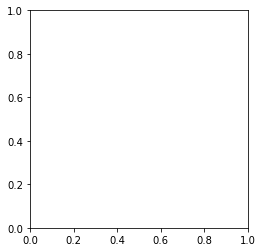

In [54]:
polygonized_gdf.plot()

In [55]:
polygonized_gdf.to_feather('polygonized_w_pins.feather')

/var/folders/6q/n3pxz9m53xq52fgdhf0cbl8h0000gn/T/ipykernel_93434/3618015081.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  polygonized_gdf.to_feather('polygonized_w_pins.feather')


In [58]:
gpd.read_feather('polygonized_w_pins.feather')['pin'].apply(type).unique()

array([<class 'numpy.ndarray'>], dtype=object)

In [60]:
polygonized_gdf['pin'].apply(type).unique()

array([<class 'list'>], dtype=object)

In [66]:
polygonized_gdf

,geometry,pin
0,"POLYGON ((1320469.675 465729.058, 1320278.867 ...","[0941D00119000000, 0941D00043000000, 0941D0013..."
1,"POLYGON ((1320278.867 465727.066, 1320469.675 ...","[0941D00119000000, 0941D00043000000, 0941D0002..."
2,"POLYGON ((1320257.992 465726.400, 1320278.867 ...","[0941D00119000000, 0941D00043000000, 0941D0013..."
3,"POLYGON ((1320117.842 465786.949, 1320121.301 ...","[0941D00119000000, 0941D00136000000, 0941D0002..."
4,"POLYGON ((1320117.808 465789.228, 1320117.842 ...","[0941D00136000000, 0941D00028000000, 0941D0013..."
...,...,...
603585,"POLYGON ((1310724.208 402283.152, 1310789.923 ...","[0148E00002000000, 8000T01114000000]"
603586,"POLYGON ((1422647.466 425211.932, 1422681.462 ...","[1239E00386000000, 8000T03554000000]"
603587,"POLYGON ((1312322.363 404008.561, 1312350.669 ...","[0149L00150000000, 8000T01319000000]"
603588,"POLYGON ((1394407.690 467581.995, 1394402.112 ...","[1084D00084000000, 8000T04434000000]"


In [64]:
import sqlalchemy
import geoalchemy2

In [65]:
# sqlalchemy.types.ARRAY(sqlalchemy.types.VARCHAR)
geoalchemy2.types.Geometry(geometry_type='POLYGON', srid=2272)

Geometry(geometry_type='POLYGON', srid=4326)

In [73]:
polygonized_gdf

,geometry,pin
0,"POLYGON ((1320469.675 465729.058, 1320278.867 ...","[0941D00119000000, 0941D00043000000, 0941D0013..."
1,"POLYGON ((1320278.867 465727.066, 1320469.675 ...","[0941D00119000000, 0941D00043000000, 0941D0002..."
2,"POLYGON ((1320257.992 465726.400, 1320278.867 ...","[0941D00119000000, 0941D00043000000, 0941D0013..."
3,"POLYGON ((1320117.842 465786.949, 1320121.301 ...","[0941D00119000000, 0941D00136000000, 0941D0002..."
4,"POLYGON ((1320117.808 465789.228, 1320117.842 ...","[0941D00136000000, 0941D00028000000, 0941D0013..."
...,...,...
603585,"POLYGON ((1310724.208 402283.152, 1310789.923 ...","[0148E00002000000, 8000T01114000000]"
603586,"POLYGON ((1422647.466 425211.932, 1422681.462 ...","[1239E00386000000, 8000T03554000000]"
603587,"POLYGON ((1312322.363 404008.561, 1312350.669 ...","[0149L00150000000, 8000T01319000000]"
603588,"POLYGON ((1394407.690 467581.995, 1394402.112 ...","[1084D00084000000, 8000T04434000000]"


In [76]:
polygonized_str_gdf = polygonized_gdf.copy()
polygonized_str_gdf['pin'] = polygonized_str_gdf['pin'].apply(lambda x: str(x).replace('[', '{').replace(']', '}'))
polygonized_str_gdf

,geometry,pin
0,"POLYGON ((1320469.675 465729.058, 1320278.867 ...","{'0941D00119000000', '0941D00043000000', '0941..."
1,"POLYGON ((1320278.867 465727.066, 1320469.675 ...","{'0941D00119000000', '0941D00043000000', '0941..."
2,"POLYGON ((1320257.992 465726.400, 1320278.867 ...","{'0941D00119000000', '0941D00043000000', '0941..."
3,"POLYGON ((1320117.842 465786.949, 1320121.301 ...","{'0941D00119000000', '0941D00136000000', '0941..."
4,"POLYGON ((1320117.808 465789.228, 1320117.842 ...","{'0941D00136000000', '0941D00028000000', '0941..."
...,...,...
603585,"POLYGON ((1310724.208 402283.152, 1310789.923 ...","{'0148E00002000000', '8000T01114000000'}"
603586,"POLYGON ((1422647.466 425211.932, 1422681.462 ...","{'1239E00386000000', '8000T03554000000'}"
603587,"POLYGON ((1312322.363 404008.561, 1312350.669 ...","{'0149L00150000000', '8000T01319000000'}"
603588,"POLYGON ((1394407.690 467581.995, 1394402.112 ...","{'1084D00084000000', '8000T04434000000'}"


In [79]:
polygonized_str_gdf.to_postgis(
  name='flat_parcels',
  con=engine,
  if_exists='replace',
  dtype={
    'geometry': geoalchemy2.types.Geometry(geometry_type='POLYGON', srid=2272),
    'pin': sqlalchemy.dialects.postgresql.ARRAY(sqlalchemy.dialects.postgresql.VARCHAR)
  }
)